# EEG Epileptic Seizure Detection Dataset

This dataset is a pre-processed and re-structured/reshaped version of a very commonly used dataset featuring epileptic seizure detection ([link from Kaggle](https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition)).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt


import sys
sys.path.append('../src')
from epilepsy import plot_sample_signals, plot_class_distribution
from utils import prepare_data, add_label_noise, prepare_ssl_data
from models.cnn import CNN1D
from models.encoder import Encoder, TC
from training import train_model, plot_training_history, train_self_supervised, relabel_dataset

In [3]:
df = pd.read_csv("../data/epilepsy/Epileptic Seizure Recognition.csv")
df.drop(columns=['Unnamed'],inplace=True)
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,-47,-11,28,77,141,211,246,240,193,136,...,-65,-33,-7,14,27,48,77,117,170,1
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,121,135,148,143,116,86,68,59,55,3


We convert to a binary classification dataset

In [4]:
dataset = df.loc[df['y'].isin([1, 2])].copy()

# Remap classes using loc:
# Old class 1 (seizure) -> New class 1 (seizure)
# Old class 2 (tumor area) -> New class 0 (no seizure)
dataset.loc[:, 'y'] = dataset['y'].map({1: 1, 2: 0})

# Verify the new class distribution
print("\nNew class distribution:")
print("Class 0 (No Seizure):", len(dataset[dataset['y'] == 0]))
print("Class 1 (Seizure):", len(dataset[dataset['y'] == 1]))


New class distribution:
Class 0 (No Seizure): 2300
Class 1 (Seizure): 2300


## Exploratory Data Analysis

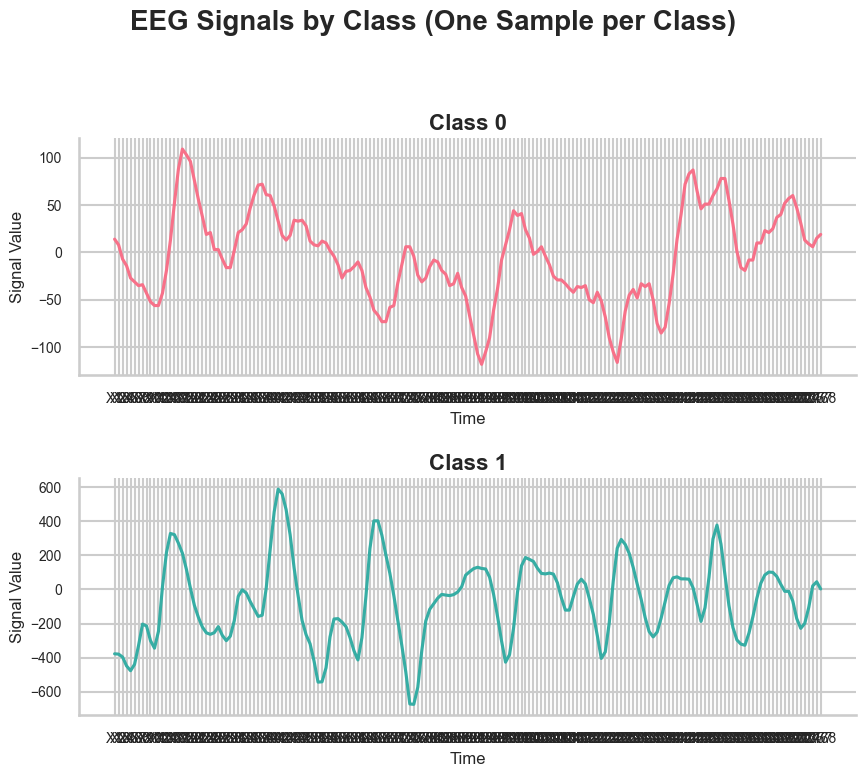

In [5]:
plot_sample_signals(dataset)

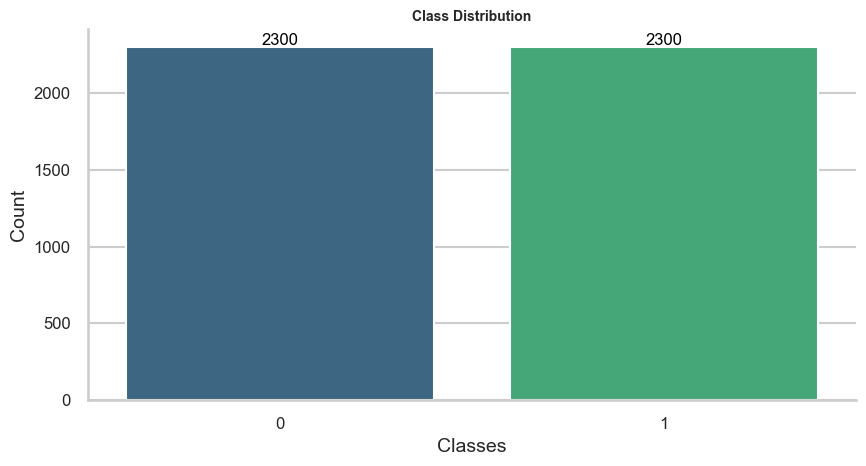

In [6]:
plot_class_distribution(dataset)

# Supervised learning using our custom 1D CNN

In [12]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Prepare data loaders
train_loader, val_loader = prepare_data(dataset, batch_size=BATCH_SIZE, train_split=0.8)

In [17]:
# Initialize model
model = CNN1D(input_size=178, num_classes=2)

In [18]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                     num_epochs=NUM_EPOCHS, device=DEVICE)

Training Progress: 100%|█| 100/100 [00:18<00:00,  5.39it/s, train_loss=0.0035, train_acc=0.9989, train_f1=0.9989, val_loss=0.0980, val_acc=0.9837, val


Training completed! Best model saved at epoch 36
Best validation Accuracy: 0.9859
Best validation F1-score: 0.9857


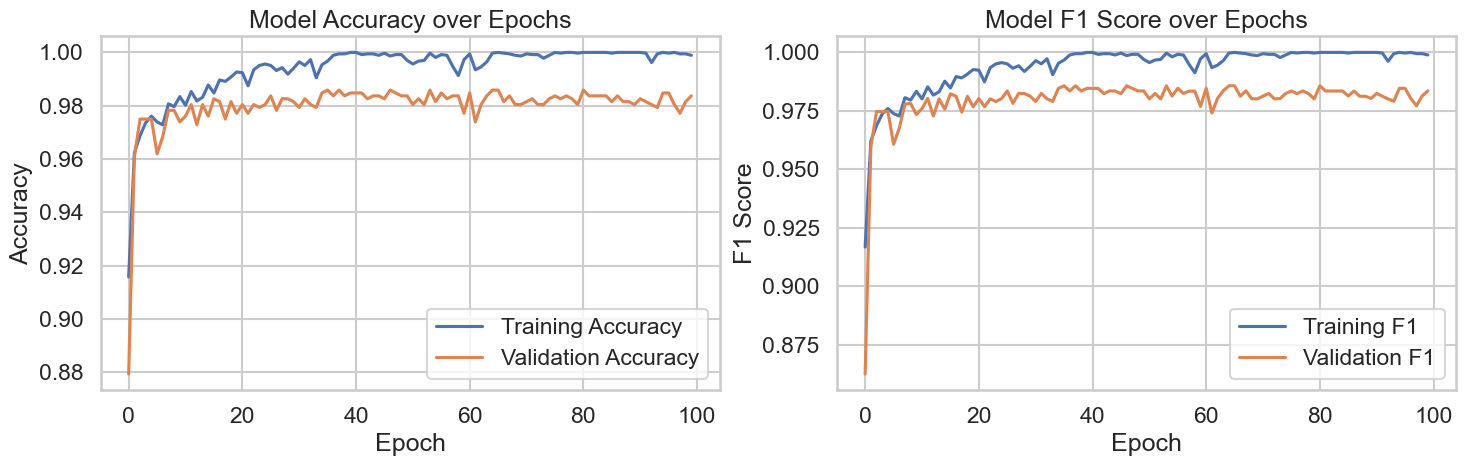

In [20]:
plot_training_history(history)


Training with 0% noise:
Requested noise ratio: 0.00%
Actual noise ratio: 0.00%
Number of flipped labels: 0

Class distribution:
Original:
y
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
y
1    0.5
0    0.5
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [00:25<00:00,  1.95it/s, train_loss=0.0058, train_acc=0.9978, train_f1=0.9978, val_loss=0.0838, val_acc=0.9826, val_f



Training completed! Best model saved at epoch 29
Best validation Accuracy: 0.9880
Best validation F1-score: 0.9879

Training with 10.0% noise:
Requested noise ratio: 10.00%
Actual noise ratio: 10.00%
Number of flipped labels: 460

Class distribution:
Original:
y
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
y
1    0.508696
0    0.491304
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [00:26<00:00,  1.92it/s, train_loss=0.0958, train_acc=0.9625, train_f1=0.9625, val_loss=0.9122, val_acc=0.8489, val_f



Training completed! Best model saved at epoch 8
Best validation Accuracy: 0.8870
Best validation F1-score: 0.8882

Training with 20.0% noise:
Requested noise ratio: 20.00%
Actual noise ratio: 20.00%
Number of flipped labels: 920

Class distribution:
Original:
y
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
y
1    0.504783
0    0.495217
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [00:25<00:00,  1.95it/s, train_loss=0.1902, train_acc=0.9280, train_f1=0.9265, val_loss=1.2470, val_acc=0.7076, val_f



Training completed! Best model saved at epoch 7
Best validation Accuracy: 0.7696
Best validation F1-score: 0.7706

Training with 30.0% noise:
Requested noise ratio: 30.00%
Actual noise ratio: 30.00%
Number of flipped labels: 1380

Class distribution:
Original:
y
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
y
0    0.502609
1    0.497391
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [00:25<00:00,  1.94it/s, train_loss=0.2704, train_acc=0.8772, train_f1=0.8659, val_loss=1.4642, val_acc=0.6152, val_f



Training completed! Best model saved at epoch 10
Best validation Accuracy: 0.6609
Best validation F1-score: 0.6541

Training with 40.0% noise:
Requested noise ratio: 40.00%
Actual noise ratio: 40.00%
Number of flipped labels: 1840

Class distribution:
Original:
y
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
y
0    0.507391
1    0.492609
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [00:25<00:00,  1.92it/s, train_loss=0.4021, train_acc=0.7946, train_f1=0.7779, val_loss=1.1951, val_acc=0.5293, val_f



Training completed! Best model saved at epoch 13
Best validation Accuracy: 0.5011
Best validation F1-score: 0.5991

Training with 50.0% noise:
Requested noise ratio: 50.00%
Actual noise ratio: 50.00%
Number of flipped labels: 2300

Class distribution:
Original:
y
1    0.5
0    0.5
Name: proportion, dtype: float64

Noisy:
y
0    0.512174
1    0.487826
Name: proportion, dtype: float64


Training Progress: 100%|█| 50/50 [00:25<00:00,  1.94it/s, train_loss=0.3957, train_acc=0.8024, train_f1=0.8016, val_loss=1.4053, val_acc=0.4957, val_f



Training completed! Best model saved at epoch 5
Best validation Accuracy: 0.5076
Best validation F1-score: 0.6190


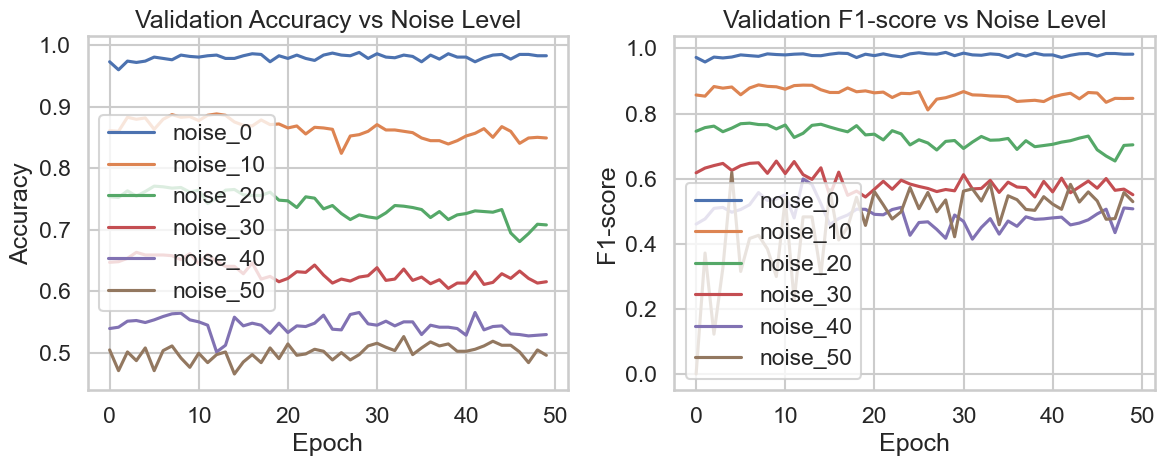

In [23]:
# Create datasets with different noise levels
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # Example: 10%, 20%, 30% noise
results = {}

for noise_level in noise_levels:
    print(f"\nTraining with {noise_level*100}% noise:")
    
    # Add noise to labels
    noisy_data = add_label_noise(dataset, noise_ratio=noise_level)
    
    # Prepare data
    train_loader, val_loader = prepare_data(noisy_data)
    
    # Train model
    model = CNN1D(input_size=noisy_data.shape[1]-1, num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    history = train_model(model, train_loader, val_loader, criterion, optimizer)
    
    # Store results
    results[f"noise_{int(noise_level*100)}"] = history

# Plot results for different noise levels
plt.figure(figsize=(12, 5))

# Plot validation accuracy for different noise levels
plt.subplot(1, 2, 1)
for noise_level in results:
    plt.plot(results[noise_level]['val_acc'], label=f'{noise_level}')
plt.title('Validation Accuracy vs Noise Level')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot validation F1 for different noise levels
plt.subplot(1, 2, 2)
for noise_level in results:
    plt.plot(results[noise_level]['val_f1'], label=f'{noise_level}')
plt.title('Validation F1-score vs Noise Level')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Self Supervised Learning

In [7]:
# Config class for hyperparameters
class Config:
    def __init__(self):
        # Model configs
        self.input_channels = 1
        self.kernel_size = 8
        self.stride = 1
        self.final_out_channels = 128
        self.features_len = 24
        self.num_classes = 2
        self.dropout = 0.35
        
        # Training configs
        self.batch_size = 128
        self.num_epochs = 100
        self.learning_rate = 3e-4
        
        # Augmentation configs
        self.jitter_scale_ratio = 0.001
        self.jitter_ratio = 0.001
        self.max_seg = 12

        # TC (Temporal Contrasting) configs
        self.TC_hidden_dim = 100
        self.TC_timesteps = 10

        # Context Contrastive configs
        self.temperature = 0.2
        self.use_cosine_similarity = True

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize config
config = Config()

# Prepare data loaders
dataset = add_label_noise(dataset, noise_ratio=0.2) # we created a 20% label noise dataset
train_loader, val_loader, test_loader = prepare_ssl_data(dataset, config)

# Initialize model
encoder = Encoder(config).to(device)
temporal_contr_model = TC(config, device).to(device)

# Train model
encoder = train_self_supervised(encoder, temporal_contr_model, train_loader, config, device)

Requested noise ratio: 20.00%
Actual noise ratio: 20.00%
Number of flipped labels: 920

Class distribution:
Original:
y
1    0.504783
0    0.495217
Name: proportion, dtype: float64

Noisy:
y
1    0.5
0    0.5
Name: proportion, dtype: float64


C:\projects\ts-ssl-label-noise\.venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/100], Loss: 11.7554
Epoch [2/100], Loss: 10.9344
Epoch [3/100], Loss: 10.6808
Epoch [4/100], Loss: 10.4261
Epoch [5/100], Loss: 10.0344
Epoch [6/100], Loss: 9.7641
Epoch [7/100], Loss: 9.5265
Epoch [8/100], Loss: 9.6608
Epoch [9/100], Loss: 9.3992
Epoch [10/100], Loss: 9.5303
Epoch [11/100], Loss: 9.2947
Epoch [12/100], Loss: 9.3137
Epoch [13/100], Loss: 9.0436
Epoch [14/100], Loss: 9.1646
Epoch [15/100], Loss: 9.1128
Epoch [16/100], Loss: 9.0018
Epoch [17/100], Loss: 9.0189
Epoch [18/100], Loss: 8.9925
Epoch [19/100], Loss: 8.8616
Epoch [20/100], Loss: 8.8121
Epoch [21/100], Loss: 9.1873
Epoch [22/100], Loss: 8.9429
Epoch [23/100], Loss: 8.9950
Epoch [24/100], Loss: 8.7720
Epoch [25/100], Loss: 9.0296
Epoch [26/100], Loss: 8.6156
Epoch [27/100], Loss: 8.8584
Epoch [28/100], Loss: 8.8029
Epoch [29/100], Loss: 8.7437
Epoch [30/100], Loss: 8.6222
Epoch [31/100], Loss: 8.4597
Epoch [32/100], Loss: 8.5904
Epoch [33/100], Loss: 8.5372
Epoch [34/100], Loss: 8.5651
Epoch [35/100], Lo

# Relabeling

In [9]:
relabeled_dataset = relabel_dataset(encoder, dataset, config, device)
relabeled_dataset

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X171,X172,X173,X174,X175,X176,X177,X178,y,label
1,386,382,356,331,320,315,307,272,244,232,...,150,146,152,157,156,154,143,129,1,1
7,1,-2,-8,-11,-12,-17,-15,-16,-18,-17,...,-91,-97,-88,-76,-72,-66,-57,-39,0,0
8,-278,-246,-215,-191,-177,-167,-157,-139,-118,-92,...,-379,-336,-281,-226,-174,-125,-79,-40,1,0
11,-167,-230,-280,-315,-338,-369,-405,-392,-298,-140,...,434,416,374,319,268,215,165,103,1,1
14,-24,-15,-5,-1,4,3,6,10,11,7,...,35,36,34,32,26,23,18,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11491,102,137,158,158,128,92,60,56,63,63,...,64,59,44,39,23,11,4,2,0,0
11492,-27,-53,-84,-104,-131,-171,-199,-203,-177,-142,...,-114,-99,-79,-56,-28,-14,-8,-12,1,0
11493,-136,-137,-138,-135,-130,-123,-116,-118,-119,-119,...,3,5,8,13,16,24,34,42,0,0
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,16,12,5,-1,-18,-37,-47,-48,0,0


In [27]:
train_loader, val_loader = prepare_data(relabeled_dataset, batch_size=BATCH_SIZE, train_split=0.8)

In [28]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                     num_epochs=NUM_EPOCHS, device=DEVICE)

Training Progress: 100%|█| 100/100 [00:16<00:00,  6.09it/s, train_loss=0.0003, train_acc=1.0000, train_f1=1.0000, val_loss=0.0573, val_acc=0.9859, val


Training completed! Best model saved at epoch 87
Best validation Accuracy: 0.9902
Best validation F1-score: 0.9268


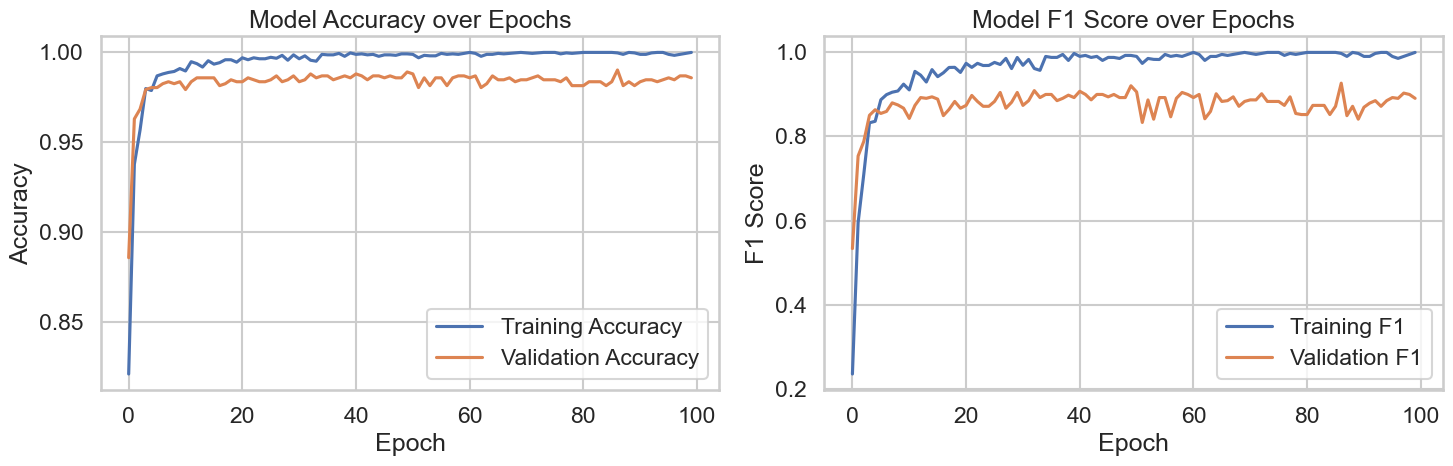

In [29]:
plot_training_history(history)